In [99]:
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm import tqdm

from calculate_preferences import calcPref, calcPrefShuffle, calcPrefNulldist

# Change to your data directory
basedir = Path('/Volumes/data-1/behavior/hakan')


### Load data

In [93]:
# Load the raw behavior data to calculate the bootstrapped distributions
data_path = basedir/'Kucukdereli_atal_data/raw_behavior_data_males.h5'
male_data = pd.read_hdf(data_path, key='data')

data_path = basedir/'Kucukdereli_atal_data/raw_behavior_data_females.h5'
female_data = pd.read_hdf(data_path, key='data')

# Load the preferences for all mice to sort the plots
data_path = basedir/'Kucukdereli_atal_data/data_table_all_mice.h5'
data_df = pd.read_hdf(data_path, key='data')


### Sort the data based on preferences on day 5 of AgRP + stress

In [94]:
males = data_df.sort_values([('test_',5)]).query('@data_df.mouse.sex=="male"')['mouse','mouse'].to_numpy()
females = data_df.sort_values([('test_',5)]).query('@data_df.mouse.sex=="female"')['mouse','mouse'].to_numpy()

# Sort the data by the preference from the day 5 of RTPP
male_data = pd.concat([male_data.query('mouse==@mouse') for mouse in males], ignore_index=True)
female_data = pd.concat([female_data.query('mouse==@mouse') for mouse in females], ignore_index=True)


In [95]:
# Additional imports and setting up the plots
import matplotlib.pyplot as plt

font = {'family' : 'sans',
        'weight' : 'regular',
        'size'   : 8}
plt.rc('font', **font)
plt.rc('axes', linewidth=0.8)

colors = {'gray':'#D4D4D4', 'darkgray':'#545454', 
          'male':'#FF5E74', 'male_light':'#FFABB6', 
          'female':'#00B7FF', 'female_light':'#9EE3FF'}


## Figure 2A

### Calculate the bootstrapped distributions and plot for individual mice

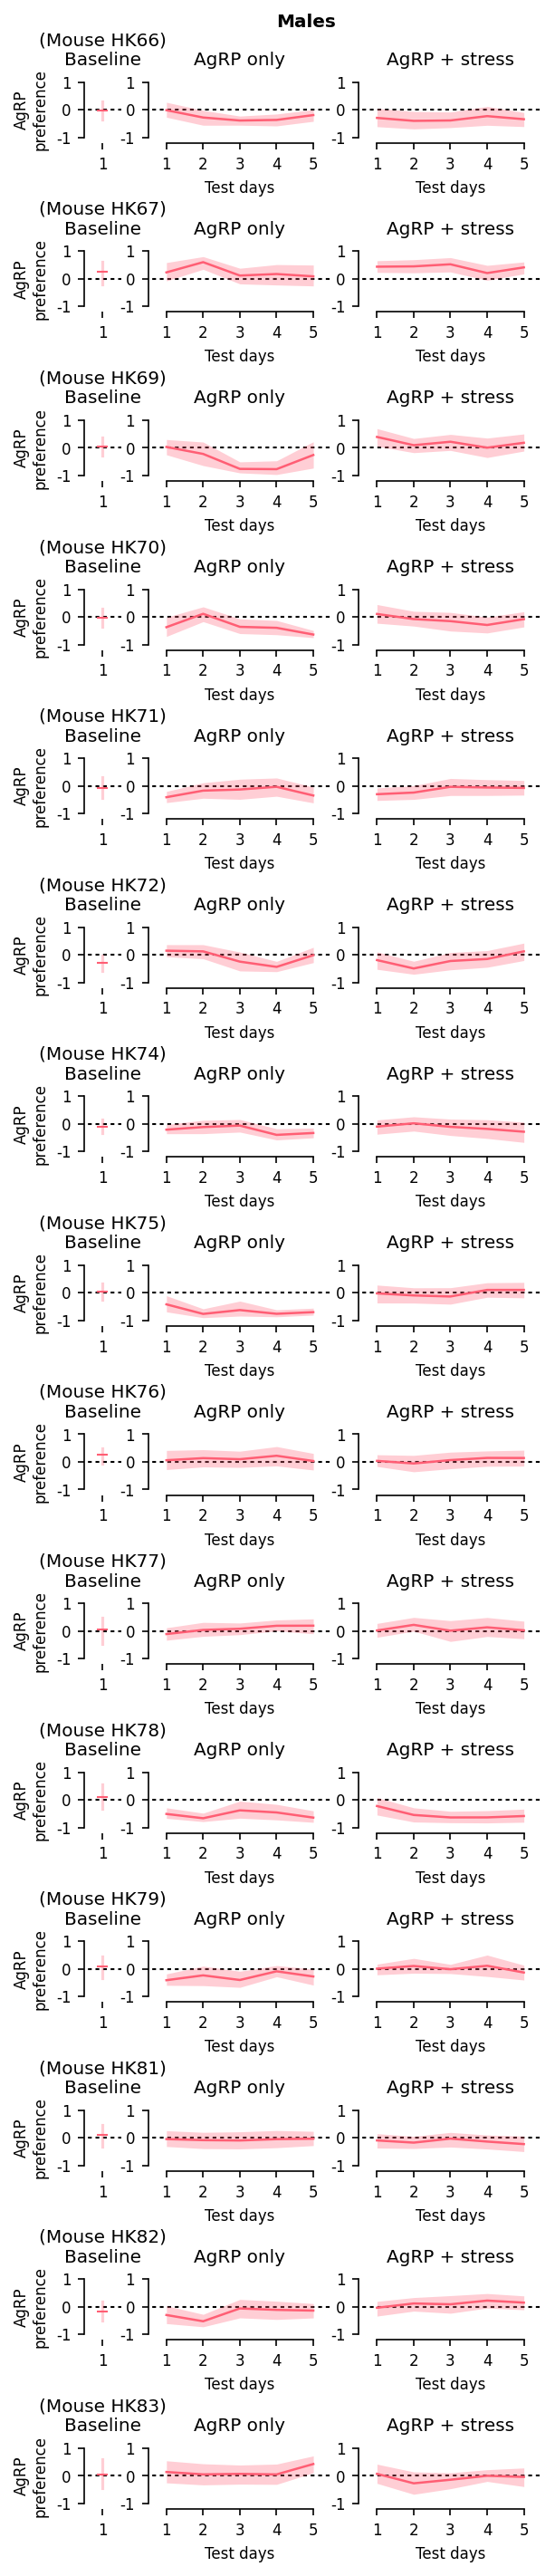

In [5]:
# Males
sex = 'male'
nshuffles = 1000

titles = {'preference':'Baseline', 'test':'AgRP only', 'test_':'AgRP + stress'}

pref_df = male_data.query('session in [1,2]').groupby(['mouse','experiment','day']).apply(calcPref, 'dwell')
shuffle_df = male_data.query('session in [1,2]').groupby(['mouse','experiment','day']).apply(calcPrefShuffle, nshuffles, 'dwell')
mice = shuffle_df.index.get_level_values('mouse').unique().to_numpy()
experiments = shuffle_df.index.get_level_values('experiment').unique().to_numpy()

fig, axs = plt.subplots(len(mice),len(experiments), figsize=(len(experiments)*1.45,len(mice)*1.55), dpi=150,
                        sharex=False, sharey=False, gridspec_kw={'wspace':0.2, 'hspace':1.55, 'width_ratios':[1,5,5]})
fig.suptitle('Males', y=0.9, fontweight='bold')

for (mouse, experiment), df in shuffle_df.apply(np.quantile, q=[.025, .975]).groupby(['mouse','experiment'], sort=False):
    days = df.index.get_level_values('day').unique().to_numpy()
    
    i, j = np.argwhere(mouse==mice).flatten()[0], np.argwhere(experiment==experiments).flatten()[0]
    ax = axs[i,j]

    ax.set_ylim(-1.2,1.2)
    ax.set_yticks([-1,0,1])
    ax.set_yticklabels([-1,0,1])

    ax.spines[['top','right']].set_visible(False)
    ax.spines['left'].set_bounds([-1,1])

    if experiment=='preference':
        ax.set_title(f'(Mouse {mouse})\n{titles[experiment]}')

        ax.set_ylabel('AgRP\npreference')

        ax.set_xlim([0.5, 1.5])
        ax.set_xticks([1])
        ax.set_xticklabels([1])
        ax.spines['bottom'].set_visible(False)

        ax.plot([0.5, 1.5], [0,0], color='k', lw=1, ls=(2,(2,2)), zorder=-1)
        ax.plot(1, pref_df.loc[mouse, experiment].mean(), color=colors[sex], marker='_', lw=1.2, clip_on=False, zorder=2)
        ax.plot([1,1], [np.concatenate(df.to_numpy()).reshape(-1, 2)[:,0].mean(), 
                        np.concatenate(df.to_numpy()).reshape(-1, 2)[:,1].mean()], 
                        color=colors[sex], lw=1.5, alpha=0.3, clip_on=False, zorder=2)
    else:
        ax.set_title(f'{titles[experiment]}')

        ax.set_xlim(0.5, 5.5)
        ax.spines['bottom'].set_bounds(1,5)
        ax.set_xticks(days)
        ax.set_xticklabels(days)
        ax.set_xlabel('Test days')

        ax.plot([days[0]-0.5, days[-1]+0.5], [0,0], color='k', lw=1, ls=(2,(2,2)), zorder=-1)
        ax.fill_between(days, np.concatenate(df.to_numpy()).reshape(-1, 2)[:,0], 
                        np.concatenate(df.to_numpy()).reshape(-1, 2)[:,1],
                        color=colors[sex], alpha=0.3, lw=0, clip_on=False, zorder=1)
        ax.plot(days, pref_df.loc[mouse, experiment].to_numpy(), color=colors[sex], lw=1.2, clip_on=False, zorder=2)


## Figure 2B

### Calculate the bootstrapped distributions and plot for individual mice

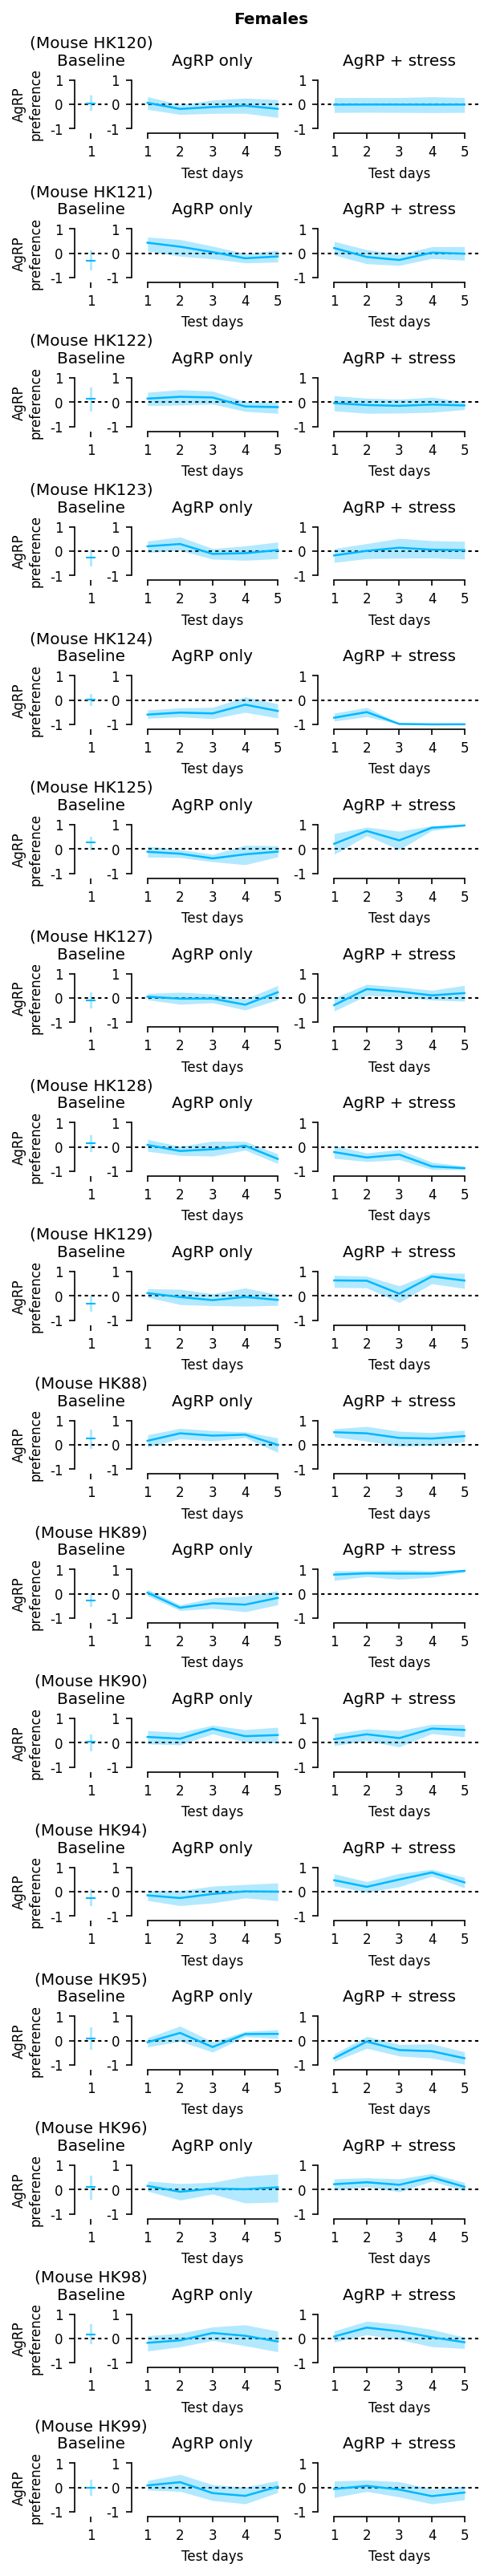

In [6]:
# Females
sex = 'female'
nshuffles = 1000

titles = {'preference':'Baseline', 'test':'AgRP only', 'test_':'AgRP + stress'}

pref_df = female_data.query('session in [1,2]').groupby(['mouse','experiment','day']).apply(calcPref, 'dwell')
shuffle_df = female_data.query('session in [1,2]').groupby(['mouse','experiment','day']).apply(calcPrefShuffle, nshuffles, 'dwell')
mice = shuffle_df.index.get_level_values('mouse').unique().to_numpy()
experiments = shuffle_df.index.get_level_values('experiment').unique().to_numpy()

fig, axs = plt.subplots(len(mice),len(experiments), figsize=(len(experiments)*1.45,len(mice)*1.55), dpi=150,
                        sharex=False, sharey=False, gridspec_kw={'wspace':0.2, 'hspace':1.55, 'width_ratios':[1,5,5]})
fig.suptitle('Females', y=0.9, fontweight='bold')

for (mouse, experiment), df in shuffle_df.apply(np.quantile, q=[.025, .975]).groupby(['mouse','experiment'], sort=False):
    days = df.index.get_level_values('day').unique().to_numpy()
    
    i, j = np.argwhere(mouse==mice).flatten()[0], np.argwhere(experiment==experiments).flatten()[0]
    ax = axs[i,j]

    ax.set_ylim(-1.2,1.2)
    ax.set_yticks([-1,0,1])
    ax.set_yticklabels([-1,0,1])

    ax.spines[['top','right']].set_visible(False)
    ax.spines['left'].set_bounds([-1,1])

    if experiment=='preference':
        ax.set_title(f'(Mouse {mouse})\n{titles[experiment]}')

        ax.set_ylabel('AgRP\npreference')

        ax.set_xlim([0.5, 1.5])
        ax.set_xticks([1])
        ax.set_xticklabels([1])
        ax.spines['bottom'].set_visible(False)

        ax.plot([0.5, 1.5], [0,0], color='k', lw=1, ls=(2,(2,2)), zorder=-1)
        ax.plot(1, pref_df.loc[mouse, experiment].mean(), color=colors[sex], marker='_', lw=1.2, clip_on=False, zorder=2)
        ax.plot([1,1], [np.concatenate(df.to_numpy()).reshape(-1, 2)[:,0].mean(), 
                        np.concatenate(df.to_numpy()).reshape(-1, 2)[:,1].mean()], 
                        color=colors[sex], lw=1.5, alpha=0.3, clip_on=False, zorder=2)
    else:
        ax.set_title(f'{titles[experiment]}')

        ax.set_xlim(0.5, 5.5)
        ax.spines['bottom'].set_bounds(1,5)
        ax.set_xticks(days)
        ax.set_xticklabels(days)
        ax.set_xlabel('Test days')

        ax.plot([days[0]-0.5, days[-1]+0.5], [0,0], color='k', lw=1, ls=(2,(2,2)), zorder=-1)
        ax.fill_between(days, np.concatenate(df.to_numpy()).reshape(-1, 2)[:,0], 
                        np.concatenate(df.to_numpy()).reshape(-1, 2)[:,1],
                        color=colors[sex], alpha=0.3, lw=0, clip_on=False, zorder=1)
        ax.plot(days, pref_df.loc[mouse, experiment].to_numpy(), color=colors[sex], lw=1.2, clip_on=False, zorder=2)
